# UFC Knowledge Graph – Analysis & Visualisation

This notebook loads the UFC ontology + instances (TTL), runs SPARQL queries with RDFLib, converts the results to Pandas DataFrames, and produces simple visualisations that help answer the competency questions.

In [1]:
# 0) Setup
from rdflib import Graph
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True

BASE = Path('.')  # current folder
ONTO_FILE = BASE / 'ufc-ontology.ttl'
INST_FILE = BASE / 'ufc-instances.ttl'

print('Files found:', ONTO_FILE.exists(), INST_FILE.exists())

Files found: True True


In [2]:
# 1) Load graph (ontology + instances)
g = Graph()
g.parse(ONTO_FILE, format='turtle')
g.parse(INST_FILE, format='turtle')
print(f'Graph loaded. Triples: {len(g):,}')

Graph loaded. Triples: 260


In [3]:
# 2) Helpers: run SPARQL to DataFrame + label handling
EX = 'http://example.org/ufc#'

def run_df(query: str) -> pd.DataFrame:
    """Run SPARQL query on the graph and return a pandas DataFrame."""
    rows = []
    for r in g.query(query):
        rows.append([str(x) if x is not None else None for x in r])
    return pd.DataFrame(rows, columns=[str(v) for v in g.query(query).vars])

def local_name(uri: str) -> str:
    if uri is None:
        return ''
    if '#' in uri:  
        return uri.split('#')[-1]
    return uri.rstrip('/').split('/')[-1]

## CQ1 – Which fighters have the most wins?
Shows the top fighters by number of `ex:hasWinner` relations.

,label,wins
0,Dustin Poirier,2
1,Charles Oliveira,1


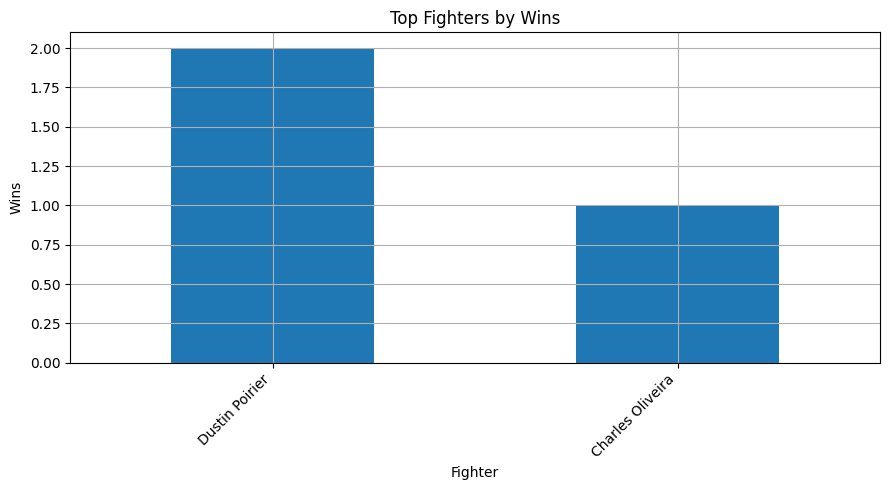

In [4]:
q_wins = '''
PREFIX ex:  <http://example.org/ufc#>

SELECT ?fighter ?name (COUNT(?fight) AS ?wins)
WHERE {
  ?fight a ex:Fight ;
         ex:hasWinner ?fighter .
  OPTIONAL { ?fighter ex:fighterName ?name }
}
GROUP BY ?fighter ?name
ORDER BY DESC(?wins)
LIMIT 20
'''

wins_df = run_df(q_wins)
if not wins_df.empty:
    # Build display label
    wins_df['label'] = wins_df.apply(lambda r: r['name'] if r['name'] else local_name(r['fighter']), axis=1)
    wins_df['wins'] = wins_df['wins'].astype(int)
    display(wins_df[['label','wins']])

    # Plot
    ax = wins_df.sort_values('wins', ascending=False).plot(kind='bar', x='label', y='wins', legend=False)
    ax.set_title('Top Fighters by Wins')
    ax.set_xlabel('Fighter')
    ax.set_ylabel('Wins')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('No wins data found (check instances).')

## CQ2 – How are fights won? (distribution of methods)
Counts fights grouped by `ex:hasMethod` (e.g., KO/TKO, Submission, Decision…).

,label,count
0,method-TKO,3


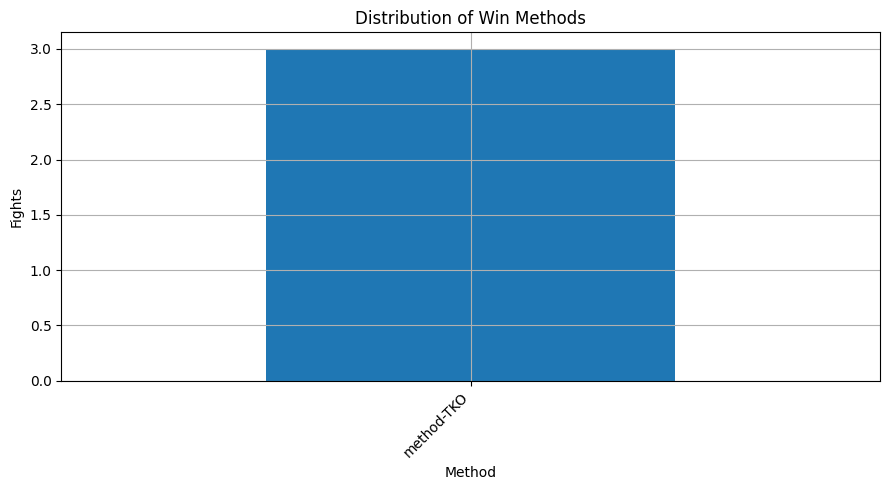

In [5]:
q_methods = '''
PREFIX ex:  <http://example.org/ufc#>

SELECT ?method (COUNT(?fight) AS ?count)
WHERE {
  ?fight a ex:Fight ;
         ex:hasMethod ?method .
}
GROUP BY ?method
ORDER BY DESC(?count)
'''

methods_df = run_df(q_methods)
if not methods_df.empty:
    methods_df['label'] = methods_df['method'].apply(local_name)
    methods_df['count'] = methods_df['count'].astype(int)
    display(methods_df[['label','count']])

    ax = methods_df.sort_values('count', ascending=False).plot(kind='bar', x='label', y='count', legend=False)
    ax.set_title('Distribution of Win Methods')
    ax.set_xlabel('Method')
    ax.set_ylabel('Fights')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('No method data found (check instances).')

## CQ3 – Title vs Non-Title ratio
Counts fights by boolean data property `ex:isTitleBout`.

,label,count
0,Non-Title Bout,2
1,Title Bout,1


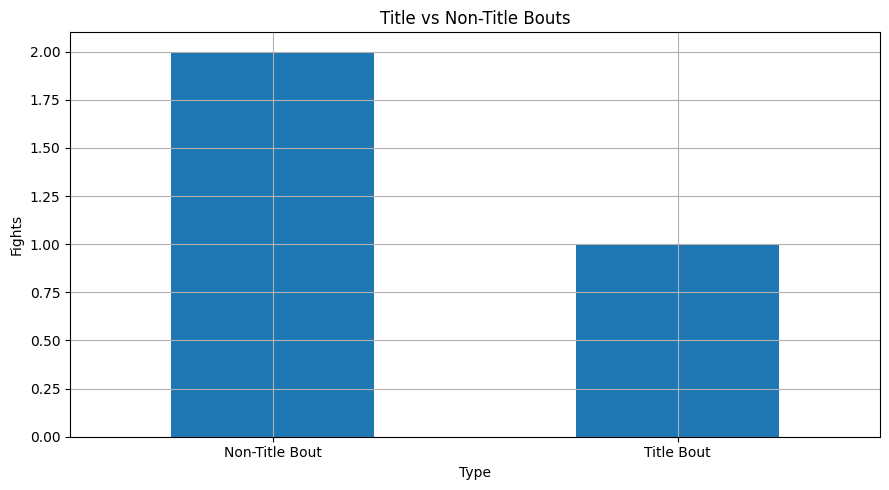

In [6]:
q_title = '''
PREFIX ex:  <http://example.org/ufc#>

SELECT ?isTitle (COUNT(?fight) AS ?count)
WHERE {
  ?fight a ex:Fight ;
         ex:isTitleBout ?isTitle .
}
GROUP BY ?isTitle
ORDER BY DESC(?count)
'''

title_df = run_df(q_title)
if not title_df.empty:
    # Cast to nicer labels if possible
    title_df['label'] = title_df['isTitle'].map({'true':'Title Bout','false':'Non-Title Bout'}).fillna(title_df['isTitle'])
    title_df['count'] = title_df['count'].astype(int)
    display(title_df[['label','count']])

    ax = title_df.plot(kind='bar', x='label', y='count', legend=False)
    ax.set_title('Title vs Non-Title Bouts')
    ax.set_xlabel('Type')
    ax.set_ylabel('Fights')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print('No title/non-title data found (check instances).')

## Extra – Events by Country
Counts distinct events per `ex:inCountry` through the event venue `ex:heldAt`.

In [7]:
q_country = '''
PREFIX ex:  <http://example.org/ufc#>

SELECT ?country (COUNT(DISTINCT ?event) AS ?events)
WHERE {
  ?event a ex:Event ; ex:heldAt ?venue .
  OPTIONAL { ?venue ex:inCountry ?country }
}
GROUP BY ?country
ORDER BY DESC(?events)
'''

country_df = run_df(q_country)
if not country_df.empty:
    country_df['label'] = country_df['country'].apply(local_name)
    country_df['events'] = country_df['events'].astype(int)
    display(country_df[['label','events']])

    ax = country_df.sort_values('events', ascending=False).plot(kind='bar', x='label', y='events', legend=False)
    ax.set_title('Events by Country')
    ax.set_xlabel('Country')
    ax.set_ylabel('Events')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('No event/venue/country data found (check instances).')

No event/venue/country data found (check instances).


## Inspect recent fights (table)
Handy for sanity-checking the graph content.

In [8]:
q_recent = '''
PREFIX ex:  <http://example.org/ufc#>

SELECT ?event ?date ?fight ?winner ?p1 ?p2
WHERE {
  ?fight a ex:Fight ;
         ex:partOfEvent ?event ;
         ex:hasWinner ?winner ;
         ex:hasParticipant ?p1 , ?p2 .
  FILTER(?p1 != ?p2)
  OPTIONAL { ?event ex:eventDate ?date }
}
LIMIT 100
'''

recent_df = run_df(q_recent)
if not recent_df.empty:
    for col in ['event','fight','winner','p1','p2']:
        recent_df[col] = recent_df[col].apply(local_name)
    display(recent_df.head(20))
else:
    print('No fights found (check instances).')

,event,date,fight,winner,p1,p2
0,event-UFC-257,2021-01-23,fight-UFC-257-1-Conor-McGregor-Dustin-Poirier,fighter-Dustin-Poirier,fighter-Conor-McGregor,fighter-Dustin-Poirier
1,event-UFC-257,2021-01-23,fight-UFC-257-1-Conor-McGregor-Dustin-Poirier,fighter-Dustin-Poirier,fighter-Dustin-Poirier,fighter-Conor-McGregor
2,event-UFC-262,2021-05-15,fight-UFC-262-1-Charles-Oliveira-Michael-Chandler,fighter-Charles-Oliveira,fighter-Charles-Oliveira,fighter-Michael-Chandler
3,event-UFC-262,2021-05-15,fight-UFC-262-1-Charles-Oliveira-Michael-Chandler,fighter-Charles-Oliveira,fighter-Michael-Chandler,fighter-Charles-Oliveira
4,event-UFC-264,2021-07-10,fight-UFC-264-1-Conor-McGregor-Dustin-Poirier,fighter-Dustin-Poirier,fighter-Conor-McGregor,fighter-Dustin-Poirier
5,event-UFC-264,2021-07-10,fight-UFC-264-1-Conor-McGregor-Dustin-Poirier,fighter-Dustin-Poirier,fighter-Dustin-Poirier,fighter-Conor-McGregor
